Below is a project where I attempt to solve the age-old problem that comes with online shopping
using **Bayesian Statistics**.

So, which one of the following item is better?
- A pair of glasses from a major brand A with an average rating of 4.1 from 1000 users
- Another pair of glasses from a start-up with an average rating of 4.5 from 16 users

Well, let's focus on item 1 for the moment, and assume:
- 10 people gave a rating of 1
- 20 people gave a rating of 2
- 30 people gave a rating of 3
- 225 people gave a rating of 4
- 148 people gave a rating of 5

In [1]:
import numpy as np
import pymc3 as pm
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

Text(0.5, 1.0, 'Rating Distribution')

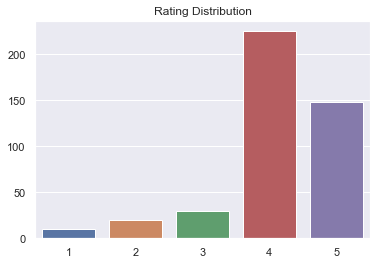

In [2]:
# The observations: the number of times an item is given a certain rating
rating_distribution_1 = np.array([10, 20, 30, 225, 148])

# Rating Scales 1 - 5
stars = np.array([1, 2, 3, 4, 5])

# Plot the rating distribution
ax = sns.barplot(x=stars, y=rating_distribution_1)
ax.set_title('Rating Distribution')

After we have got everything input and set up in Python, we can use Pymc3 to run the simulations for us.

I won't go into the details of Bayesian Statistics as it's out of the scope of this article.

Essentially, what it can give us, is **an adjusted rating** that basically **penalizes** items with ratings given by fewer users.

It can be a bit dry to explain that way, so let's plug in this real world example and run some simulations.

In [3]:
def simulation(rating_distribution):
    # Total Number of ratings
    n = np.sum(rating_distribution)

    # Total Number of choices
    m = len(stars)

    # Probability of each choice if the rating is given randomly
    p = 1/m

    # Average Rating
    rating_avg = (rating_distribution * stars).sum()/n
    print('Average Rating:', rating_avg)

    with pm.Model() as model:
        # Initialize the Dirichlet distribution with a uniform prior
        a = np.ones(m)
        theta = pm.Dirichlet('theta', a=a)

        rating_true = pm.Deterministic('rating', (theta*stars).sum())

        results = pm.Multinomial('results', n=n, p=theta, observed=rating_distribution)

    with model:
        trace = pm.sample(draws=2000)

    ax = pm.plot_posterior(trace, var_names=['rating'])
    ax.set_title('P(Rating = X)')

    rating_adjusted = np.quantile(trace['rating'], 0.05)
    print(rating_adjusted)

Average Rating: 4.1108545034642034


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


4.025586445164931


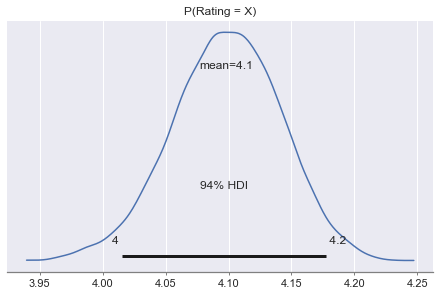

In [4]:
simulation(rating_distribution_1)

Average Rating: 4.5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.6687808080243777, but should be close to 0.8. Try to increase the number of tuning steps.


3.726851932509178


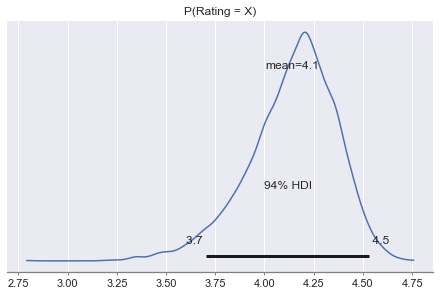

In [5]:
# Ratings for glasses 2
rating_distribution_2 = np.array([0, 0, 0, 8, 8])
simulation(rating_distribution_2)

A few remarks here:
- Graph 1 shows that the underlying rating(a proxy for quality) for glasses 1 is **above 4** at a **95% chance**.
- Graph 2 shows that the underlying rating for glasses 2 is **above only 3.7** at a **95% chance**.
- Even though the average rating for glasses 2 is 4.5, **the chance of that happening(the true quality worth a 4.5 rating) is only 5%**!

Therefore, based on the simulation results, I'd pick glasses 1!

To put the whole technique into practice, I applied the technique on the
[yelp dataset](https://www.yelp.com/dataset/documentation/main), with an approximation formula since
it'd be computationally super expensive to run pymc3 for each restaurant.

The demo can be found [here](https://share.streamlit.io/raychn1997/bayesian-rater/main.py) .